**Chapter 4**
learning CNN's 

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset,TensorDataset,DataLoader

In [ ]:
from torch.optim import Adam, sgd
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import numpy as np
import matplotlib.pyplot  as plt
%matplotlib inline

In [ ]:
X_train = torch.tensor(
    [[
        [[1,2,3,4],[2,3,4,5],[3,4,5,6],[3,4,5,7]]
    ],
    [
        [[1,2,3,4],[2,3,44,5],[3,4,5,2],[3,4,5,7]]
    ]]
).to(device).float()

In [ ]:
X_train/=8
y_train = torch.tensor([0,1]).to(device).float()

In [ ]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1,1,kernel_size=3),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1,1),
        nn.Sigmoid()
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(),1e-3)
    return model,loss_fn,optimizer

In [ ]:
from torchsummary import summary
model, loss_func,optimizer = get_model()
summary(model,X_train)

In [ ]:
def train_batch(x,y,model,opt,loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction.squeeze(0),y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()
    

In [ ]:
train_dl = DataLoader(TensorDataset(X_train,y_train))

In [ ]:
for epoch in range(500):
    for ix,batch in enumerate(iter(train_dl)):
        x,y = batch
        batch_loss = train_batch(x,y,model=model,opt=optimizer,loss_fn=loss_func)

In [ ]:
model(X_train[-1])

In [ ]:
y[-1]

## Classifying FMNIST images Using CNN

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader,Dataset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data_folder = './data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder,download=True, train=True)
fmnist_images = fmnist.data
fmnist_targets = fmnist.targets

val_fmnist = datasets.FashionMNIST(data_folder,download=False, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets




In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x,self.y = x,y
    def __getitem__(self,ix):
        return self.x[ix],self.y[ix]
    def __len__(self):
        return len(self.x)

In [ ]:
from torch.optim import SGD,Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1,64,kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200,256),
        nn.ReLU(),
        nn.Linear(256,10)
    )
    loss_func = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(),lr=1e-3)
    return model,loss_func,optimizer

In [ ]:
from torchsummary import summary

model,loss_fn,optimizer = get_model()
summary(model,torch.zeros(1,1,28,28))

In [ ]:
def get_data():
    train_ds = FMNISTDataset(fmnist_images,fmnist_targets)
    trn_dl = DataLoader(train_ds,batch_size=1000,shuffle=True)

    val_ds = FMNISTDataset(val_images,val_targets)
    val_dl = DataLoader(val_ds,batch_size=len(val_ds),shuffle=True)

    return trn_dl,val_dl

In [ ]:
def train_batch(x,y,model,opt,loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction.squeeze(0),y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()
    

In [ ]:
@torch.no_grad
def validate(x,y,model,loss_fn):
    model.eval()
    prediction = model(x)
    batch_loss = loss_fn(prediction,y)
    maxval,maxarg = prediction.max(-1)
    is_correct = maxarg == y
    return  torch.mean(is_correct.float()),batch_loss.item()

In [ ]:
trn_dl,val_dl = get_data()
model,loss_fn,optimizer = get_model()
epoch_losses = []
validation_loss_epoch = []

training_accuracies ,training_losses =[],[]
validation_accuracies,validation_losses = [],[]
for epoch in range(3):
    for ix,batch in enumerate(iter(trn_dl)):
        x,y = batch
        batch_loss = train_batch(x,y,model=model,opt=optimizer,loss_fn=loss_fn)
        batch_accuracy ,batch_loss = validate(x,y,model,loss_fn)
        print(f'epoch number is {epoch}\n\t ix: {ix}')
    training_losses.append(np.mean(batch_loss))
    training_accuracies.append(batch_accuracy)
    for ix,batch in enumerate(iter(val_dl)):
        x,y = batch
        validation_accuracy,validation_loss = validate(x,y,model=model,loss_fn=loss_fn)
        print(f'epoch number is {epoch}\n\t ix inside dataloader: {ix}\n\tbatch_loss:{batch_loss}\n\tevaluation_result')
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

NameError: name 'get_data' is not defined

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

epochs = np.arange(3) + 1
plt.subplot(211)
plt.plot(epochs,training_losses,'bo',label = 'Training Loss')
plt.plot(epochs,validation_losses, label = 'Validation Loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()


plt.subplot(212)
plt.plot(epochs,training_accuracies,'bo',label = 'Training Loss')
plt.plot(epochs,validation_accuracies, label = 'Validation Loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('off')
plt.show()

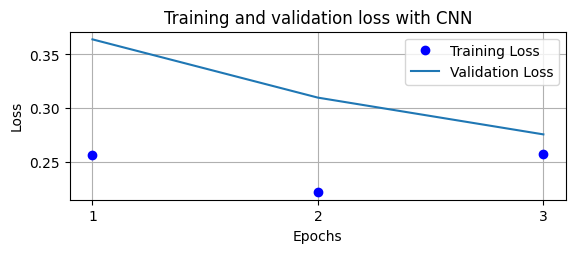

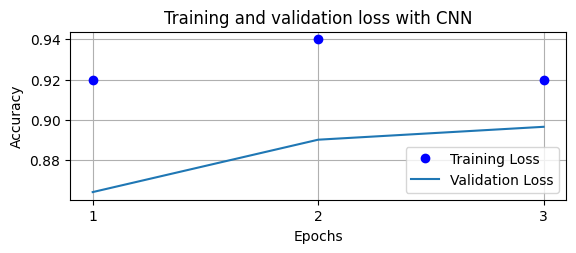